## Setup

In [1]:
!nvidia-smi

Sun Sep 26 11:26:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install -q tensorflow-addons

     |████████████████████████████████| 1.1 MB 6.1 MB/s 


## Data Gathering

In [2]:
!wget -q http://data.vision.ee.ethz.ch/ihnatova/camera_scene_detection_train.zip
!unzip -qq camera_scene_detection_train.zip

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
from pprint import pprint
from collections import Counter
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_addons as tfa

SEEDS = 42

tf.random.set_seed(SEEDS)
np.random.seed(SEEDS)

## Data Parsing

In [2]:
image_paths = list(paths.list_images("training"))
np.random.shuffle(image_paths)
image_paths[:5]

['training/29_QR_images/14.jpg',
 'training/4_Dog/219.jpg',
 'training/17_Cloudy_Sky/174.jpg',
 'training/12_Landscape/46.jpg',
 'training/22_Stage_concert/234.jpg']

## Counting number of images for each classes

In [3]:
labels = []
for image_path in image_paths:
    label = image_path.split("/")[1]
    labels.append(label)
class_count = Counter(labels) 
pprint(class_count)

Counter({'4_Dog': 502,
         '14_Architecture': 463,
         '15_Sunset_Sunrise': 420,
         '7_Food': 400,
         '5_Cat': 373,
         '6_Macro': 357,
         '9_Mountain': 352,
         '11_Snow': 344,
         '12_Landscape': 335,
         '8_Beach': 334,
         '10_Waterfall': 326,
         '2_Group_portrait': 324,
         '22_Stage_concert': 322,
         '16_Blue_Sky': 322,
         '1_Portrait': 319,
         '23_Fireworks': 317,
         '21_Night_shot': 316,
         '24_Candle_light': 313,
         '30_Computer_Screens': 308,
         '17_Cloudy_Sky': 307,
         '28_Text_Documents': 306,
         '26_Indoor': 298,
         '13_Underwater': 296,
         '19_Autumn_leaves': 295,
         '18_Greenery': 294,
         '3_Kids': 281,
         '27_Backlight': 280,
         '20_Flower': 279,
         '25_Neon_lights': 269,
         '29_QR_images': 245})


## Define Hyperparameters

In [4]:
TRAIN_SPLIT = 0.9
BATCH_SIZE = 128
AUTO = tf.data.AUTOTUNE
EPOCHS = 100
IMG_SIZE = 224
RESIZE_TO = 260
NUM_CLASSES = 30
WEIGHT_DECAY = 0.0001
SCHEDULE_LENGTH = 500
SCHEDULE_BOUNDARIES = [200, 300, 400]

## Splitting the dataset

In [5]:
i = int(len(image_paths) * TRAIN_SPLIT)

train_paths = image_paths[:i]
train_labels = labels[:i]
validation_paths = image_paths[i:]
validation_labels = labels[i:]

print(len(train_paths), len(validation_paths))

8907 990


## Encoding labels

In [6]:
label_encoder = LabelEncoder()
train_labels_le = label_encoder.fit_transform(train_labels)
validation_labels_le = label_encoder.transform(validation_labels)
print(train_labels_le[:5])

[20 24  7  2 13]


## Determine the class-weights

In [7]:
trainLabels = keras.utils.to_categorical(train_labels_le)
classTotals = trainLabels.sum(axis=0)
classWeight = dict()
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

## Convert the data into TensorFlow `Dataset` objects

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels_le))
val_ds = tf.data.Dataset.from_tensor_slices((validation_paths, validation_labels_le))

## Define the preprocessing function

In [9]:
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE


@tf.function  
def preprocess_train(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = tf.image.random_crop(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32) / 255.0
    return (image, label)

@tf.function
def preprocess_test(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return (image, label)

## Data Augmentation

In [10]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
        tf.keras.layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

## Create the Data Pipeline

In [11]:
pipeline_train = (
    train_ds
    .shuffle(BATCH_SIZE * 100)
    .map(preprocess_train, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

pipeline_validation = (
    val_ds
    .map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Visualise the training images

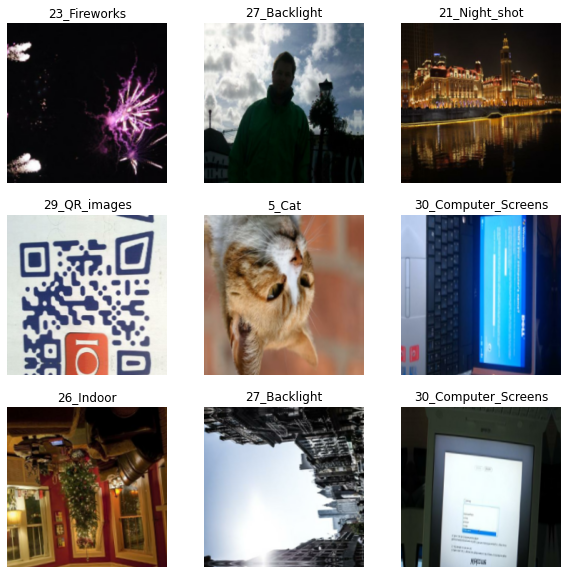

In [12]:
image_batch, label_batch = next(iter(pipeline_train))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy())
    label = label_batch[i]
    plt.title(label_encoder.inverse_transform([label.numpy()])[0])
    plt.axis("off")

## Load model into KerasLayer

In [13]:
vit_model_url = "https://tfhub.dev/sayakpaul/vit_s16_classification/1"

model = keras.Sequential(
    [
        keras.layers.InputLayer((IMG_SIZE, IMG_SIZE, 3)),
        hub.KerasLayer(vit_model_url),
        keras.layers.Dense(NUM_CLASSES, activation="softmax"),
    ]
)

## Define optimizer and loss

In [14]:
lr = 0.003 * BATCH_SIZE / 512 

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.01, lr*0.001])

optimizer = tfa.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=WEIGHT_DECAY)
loss_fn = keras.losses.SparseCategoricalCrossentropy()

## Compile the model

In [15]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

## Setup Callbacks

In [17]:
train_callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    keras.callbacks.CSVLogger('./train-logs.csv'),
    keras.callbacks.TensorBoard(histogram_freq=1)
]

## Train the model

In [18]:
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    epochs= EPOCHS, 
    validation_data=pipeline_validation,
    class_weight=classWeight,
    callbacks=train_callbacks)

Epoch 1/100
70/70 [==============================] - 61s 720ms/step - loss: 1.9995 - accuracy: 0.6590 - val_loss: 0.4413 - val_accuracy: 0.8576
Epoch 2/100
70/70 [==============================] - 46s 639ms/step - loss: 0.6265 - accuracy: 0.8789 - val_loss: 0.3272 - val_accuracy: 0.9051
Epoch 3/100
70/70 [==============================] - 46s 642ms/step - loss: 0.4863 - accuracy: 0.9036 - val_loss: 0.2896 - val_accuracy: 0.9152
Epoch 4/100
70/70 [==============================] - 47s 654ms/step - loss: 0.4185 - accuracy: 0.9168 - val_loss: 0.2705 - val_accuracy: 0.9172
Epoch 5/100
70/70 [==============================] - 48s 658ms/step - loss: 0.3891 - accuracy: 0.9241 - val_loss: 0.2707 - val_accuracy: 0.9202
Epoch 6/100
70/70 [==============================] - 49s 683ms/step - loss: 0.4057 - accuracy: 0.9217 - val_loss: 0.2702 - val_accuracy: 0.9202
Epoch 7/100
70/70 [==============================] - 48s 668ms/step - loss: 0.4029 - accuracy: 0.9191 - val_loss: 0.2704 - val_accuracy:

## Plot the Metrics

In [19]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()

## Evaluate the model

8/8 [==============================] - 4s 454ms/step - loss: 0.2707 - accuracy: 0.9202
Accuracy: 92.02%


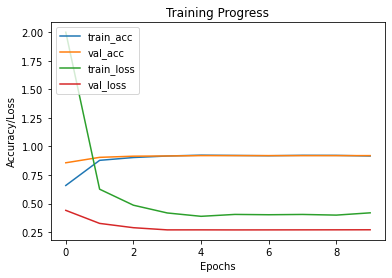

In [20]:
accuracy = model.evaluate(pipeline_validation)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))
plot_hist(history)

## Upload the TensorBoard logs

In [ ]:
!tensorboard dev upload --logdir logs --name "ViT baseline on image scene dataset" --description "Baseline model of ViT in image scene dataset - Experiment1" 

**Link:** https://tensorboard.dev/experiment/rTRHnQhaRCqfZ8EuW84uGQ/